In [50]:
import glob
import os
import numpy as np
import subprocess
import sys

from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
from astropy import units as u

from photutils import SkyCircularAnnulus, SkyCircularAperture, aperture_photometry
from regions import CircleSkyRegion

import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.colors import LogNorm

In [2]:
sas_dir = "/home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155"
os.environ["SAS_DIR"] = sas_dir
os.environ["SAS_PATH"] = os.environ["SAS_DIR"]
os.environ["SAS_VERBOSITY"] = "4"
os.environ["SAS_SUPPRESS_WARNING"] = "1"
path = os.environ["PATH"]
os.environ["PATH"] = f"{sas_dir}/bin:{sas_dir}/binextra:{path}"
if "LD_LIBRARY_PATH" in os.environ.keys():
    ld_path = os.environ["LD_LIBRARY_PATH"]
# lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}/libsys:{ld_path}"
lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}"
os.environ["LD_LIBRARY_PATH"] = lib_path
os.environ["PERL5LIB"] = "{}/lib/perl5".format(sas_dir)
os.environ['SAS_CCFPATH'] = "/home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155/calibration"
!sasversion
!perl -e "print qq(@INC)"

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2020-06-12T09:31:36.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:18 CEST 2019
Compiled by: sasbuild@sasbld03n
Platform   : Ubuntu16.04 64

SAS-related environment variables that are set:

SAS_DIR = /home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155
SAS_PATH = /home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155
SAS_CCFPATH = /home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155/calibration

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2020-06-12T09:31:36.000
/home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155/lib/perl5 /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.26.1 /usr/local/share/perl/5.26.1 /usr/lib/x86_64-linux-gnu/perl5/5.26 /usr/share/perl5 /usr/lib/x86_64-linux-g

In [3]:
def exec_task(task, verbose=True):
    try:
        # Write the shell output to tmp.log file.
        fout = open("tmp.log", "w")
        result = subprocess.run(task, shell=True, stdout=fout, stderr=subprocess.STDOUT)
        retcode = result.returncode
        fout.close()
        if retcode < 0:
            if (verbose):
                print(f"Execution of {task} was terminated by code {-retcode}.", file=sys.stderr)
        else:
            if (verbose):
                print(f"Execution of {task} returned {retcode}.", file=sys.stderr)
    except OSError as e:
        print(f"Execution of {task} failed:", e, file=sys.stderr)
    return retcode

In [4]:
def get_coords(odf_dir):
    logs_list = glob.glob("{}/logs/rad_prof*".format(odf_dir))
    aux = False
    aux_r = []
    circle = ""
    for log in logs_list:
        if not aux:
            with open(log, "r") as f:
                for line in f:
                    if "CIRCLE: " in line:
                        #circle = line.split(" ")[1]
                        circle = line.split("- ")[1].split(" ")[1]
                        #print(circle)
                if circle != "":
                    aux_r.append(float(circle.split(',')[2]))
                    #aux = True
    RA = float(circle.split(',')[0])
    DEC = float(circle.split(',')[1])
    r = max(aux_r)
    print(RA, DEC, r)
    return [RA, DEC, r]

In [5]:
def get_outoftime_evts():
    bll_catalog = fits.open('/home/aaranda/tfm/bllacs_TFM_Adrian.fits')
    data = bll_catalog[1].data
    OutOfTime_list = []
    for row in data:
        if row[8] == 'SI':
            OutOfTime_list.append(row[4])
    return OutOfTime_list

In [46]:
obsid_list = get_outoftime_evts()
print(obsid_list)

['0721890101', '0084140101', '0084140501', '0604210201', '0604210301', '0152900201', '0123100201', '0830190501', '0303820301', '0112830201', '0112830501', '0104860501', '0124900101', '0790380501', '0790380601', '0790380801', '0790381401', '0790381501', '0790380901', '0761100101', '0761100201', '0761100301', '0761100401', '0761101001']


In [59]:
wdir = "/home/aaranda/tfm/obsid"
bll_catalog = fits.open('/home/aaranda/tfm/bllacs_PN_NopileupNofasttiming.fits')
obsid = '0084140101'
odf_dir = "{}/{}".format(wdir, obsid)
fitsfile = '{}/images/image_filtered_low.fits'.format(odf_dir)

qhdu = fits.open(fitsfile)
data = qhdu[0].data
wcs = WCS(qhdu[0].header)
coords = get_coords(odf_dir)
print(coords)
center = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')

py, px = wcs.wcs_world2pix(coords[0], coords[1], 1)
print('{0} {1}'.format(px, py))

print(data[int(px), int(py)])

32.1592 35.3869 0.03333333333333333
[32.1592, 35.3869, 0.03333333333333333]
339.06956165189257 346.43267548442464
985


In [66]:
pix_area = utils.proj_plane_pixel_area(wcs)
print(np.sqrt(pix_area) * 3600)

rad = 4 * 60
pixels = int(rad / 4)
print(pixels)

x_inf = int(px)-pixels
x_sup = int(px)+pixels
y_inf = int(py)-pixels
y_sup = int(py)+pixels

3.999999999999996
60


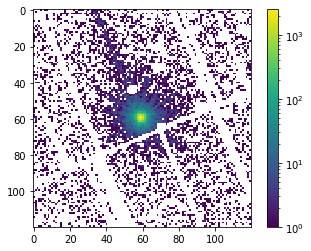

In [72]:
plt.imshow(data[x_inf:x_sup, y_inf:y_sup], norm=LogNorm())
#plt.imshow(data, norm=LogNorm())
plt.colorbar()
plt.show()